In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

### Data Acquisition

#### Create DataFrame

* Create dataframe with image_path, time(seconds) and speed

* In the video given, we have ~344 (5min 44s) seconds of video. 
* Our ground truth labels correspond to a video that is 12m 12s (~732seconds). 
* We only have a portion of that video. 
* It appears that our framerate <strong>~ 13 fps </strong>. (4459 frames * (1 second / 13frames) = 344 seconds)

In [2]:
df = pd.read_csv('./data/driving.csv')
df.head(10)
len(df)

4459

In [3]:
valid_data = df[3541:4459]
train_data = df[0:3540]

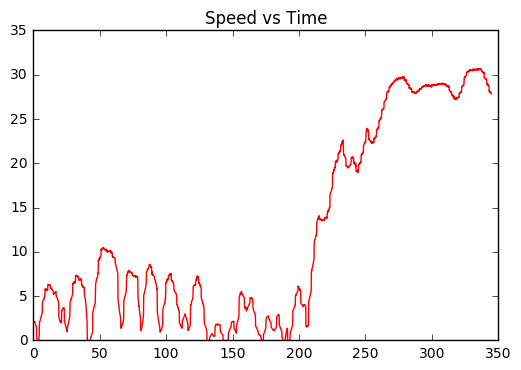

In [4]:
times = np.asarray(df['time'], dtype = np.float32)
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [5]:
df.tail(5)

,image_path,time,speed
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


## Preprocess

In [6]:
def change_brightness(image):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    bright_factor = 0.2 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

#### Perspective Transform

In [7]:
def apply_perspective_transform(image):
    pass

In [8]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (256, 256, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             2) Perspective transform
             3) resize to (256, 256, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    
    # TODO: Write perspective transform 
#     perspective = apply_perspective_transform(image_cropped)
    
    image = cv2.resize(image_cropped, (227, 227), interpolation = cv2.INTER_AREA)
    
    return image

In [9]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

In [10]:
def preprocess_image_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = change_brightness(img)

            
    img = preprocess_image(img)
    return img, speed

### Generators

In [11]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 227, 227, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data) - 1)
            row1 = data.iloc[[idx]].reset_index()
            row2 = data.iloc[[idx + 1]].reset_index()
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], row2['speed'].values[0])
           
            # stack images
            x = np.concatenate(x1, x2, axis = 0)
            
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = x
            label_batch[i] = y
            
        yield shuffle(image_batch, label_batch)

In [12]:
# stack mode
def generate_validation_data(data):
    while True:
        for idx in range(len(data) - 1):
            row1 = data.iloc[[idx]].reset_index()
            row2 = data.iloc[[idx + 1]].reset_index()
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            s1 = row1['speed'].values[0]
            s2 = row2['speed'].values[0]
            
            # Stack the images to send into the model
            img_stack = np.concatenate(x1, x2, axis = 0)
            
            img_stack = img_stack.reshape(1, img_stack.shape[0], img_stack.shape[1], img_stack.shape[2])
            
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_stack, speed

### Network Architecture (DeepVO AlexNetLike)

### Cross Channel Normalization function

In [13]:
import numpy as np
from keras.layers.core import  Lambda, Merge
from keras.layers.convolutional import Convolution2D
from keras import backend as K

from keras.engine import Layer

def crosschannelnormalization(alpha = 1e-4, k=2, beta=0.75, n=5,**kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        b, ch, r, c = X.shape
        half = n // 2
        square = K.square(X)
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0,2,3,1))
                                              , (0,half))
        extra_channels = K.permute_dimensions(extra_channels, (0,3,1,2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:,i:i+ch,:,:]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape:input_shape,**kwargs)

Using TensorFlow backend.


In [14]:
from keras.layers import Input, Dense, Activation, Flatten, merge, Lambda, Dropout
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.optimizers import Adam
from CustomLayers import LRN2D


tf.python.control_flow_ops = tf


N_img_height = 227
N_img_width = 227
N_img_channels = 3

# inputShape = (N_img_height, N_img_width, N_img_channels)
def splitTensor(tensor):
    """
    Out inputs come in as two stacked (?, 227, 227 ,3) images 
    tensor shape: (?, 454, 227, 3)
    output: split1: tensor (?, 227, 227, 3)
            split2: tensor (?, 227, 227, 3)
    """
    split1 = tensor[:, 0:227,:,:]
    split2 = tensor[:, 227:454,:,:]
    return split1, split2
    

def DeepVo():
    # TODO: Maybe add zeroPadding2D(1, 1) after each layer
    # TODO: Maybe take out input_shape = inputShape from first conv layer
    
    ALPHA = 0.00001
    BETA = 0.75
    DIM_ORDERING = 'tf'
    
    
    inputShape = (N_img_height * 2, N_img_width, N_img_channels)
    inputShapeSingle = (N_img_height, N_img_width, N_img_channels)
    
    inputImg = Input(shape = inputShape)
    
#     x = Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape)
    
#     print('inputImg shape:: ', inputImg.get_shape)
    
    x, y = splitTensor(inputImg)
    
    x = Lambda(lambda a: a / 127.5 - 1, input_shape = inputShapeSingle)(x)
    
    y = Lambda(lambda b: b / 127.5 - 1, input_shape = inputShapeSingle)(y)
    
#     print('x shape: ', x.get_shape)
#     print('y shape: ', y.get_shape)
    print(type(x))
    
    ######## LAYER 1 ####################
    # Convolution Layer 1: Channel 1
    x1 = Convolution2D(96, 11, 11, subsample=(4, 4), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu',
                      input_shape = inputShapeSingle,  # may not be necessary
                      name = 'conv_1_x')(x)

    # Convolution Layer 1: Channel 2
    y1 = Convolution2D(96, 11, 11, subsample=(4, 4), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu',
                      input_shape = inputShapeSingle,  # may not be necessary
                      name = 'conv_1_y')(y)
    ### TODO: ADD NORMALIZATION to X1
#     x1 = crosschannelnormalization(x1)
    
    
    ### TODO: ADD NORMALIZATION TO Y1
    
    # Max Pooling Layer 1: Channel 1
    x1 = MaxPooling2D((3, 3), strides = (2, 2), dim_ordering=DIM_ORDERING)(x1)
    # Max Pooling Layer 1: Channel 2
    y1 = MaxPooling2D((3, 3), strides = (2, 2), dim_ordering=DIM_ORDERING)(y1)
    ######## END OF LAYER 1 ####################

    ######## LAYER 2####################
    # Convolution Layer 2: Channel 1
    x1 = Convolution2D(256, 5, 5, subsample = (1, 1), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu', 
                      name = 'conv_2_x')(x1)

    # Convolution Layer 2: Channel 2
    y1 = Convolution2D(256, 5, 5, subsample = (1, 1), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu', 
                      name = 'conv_2_y')(y1)
    
    # Zero Padding (2, 2) on ConvLayer2: Channel 1
    x1 = ZeroPadding2D(padding = (2, 2), dim_ordering=DIM_ORDERING)(x1)

    # Zero Padding (2, 2) on ConvLayer2: Channel 2
    y1 = ZeroPadding2D(padding = (2, 2), dim_ordering=DIM_ORDERING)(y1)
    
    #TODO: Add cross channel normalizations
    
    # Max Pooling Layer 1: Channel 1
    x1 = MaxPooling2D((3, 3), strides = (2, 2))(x1)
    
    # Max Pooling Layer 1: Channel 2
    y1 = MaxPooling2D((3, 3), strides = (2, 2))(y1)
    
    ####### LAYER 3 ###################
    # Convolution Layer 3: Channel 1
    x1 = Convolution2D(384, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_3_x')(x1)

    # Convolution Layer 3: Channel 2
    y1 = Convolution2D(384, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_3_y')(y1)
    
    # Zero Padding (1, 1) on Layer 3 channel 1
    x1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(x1)
    
    # Zero Padding (1, 1) on Layer 3 channel 2
    y1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(y1)
    
    
    ####### LAYER 4 ###################
    # Convolution Layer 4: Channel 1
    x1 = Convolution2D(384, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_4_x')(x1)

    # Convolution Layer 4: Channel 2
    y1 = Convolution2D(384, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_4_y')(y1)
    
    # Zero Padding (1, 1) on Layer 4 channel 1
    x1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(x1)
    
    # Zero Padding (1, 1) on Layer 4 channel 2
    y1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(y1)
    
    ####### LAYER 5 ###################
    # Convolution Layer 5: Channel 1
    x1 = Convolution2D(256, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_5_x')(x1)

    # Convolution Layer 5: Channel 2
    y1 = Convolution2D(256, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_5_y')(y1)
    
    
    # Zero Padding (1, 1) on Layer 5 channel 1
    x1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(x1)
    
    # Zero Padding (1, 1) on Layer 5 channel 2
    y1 = ZeroPadding2D(padding = (1, 1), dim_ordering=DIM_ORDERING)(y1)
    
    
    # Pool Layer 5
    # Max Pooling Layer 5: Channel 1
    x1 = MaxPooling2D((3, 3), strides = (2, 2), dim_ordering=DIM_ORDERING )(x1)
    
    # Max Pooling Layer 5: Channel 2
    y1 = MaxPooling2D((3, 3), strides = (2, 2), dim_ordering=DIM_ORDERING)(y1)
    
    # reduce from 4 dimensions (?, 6, 6, 256) -> (?, 43264) so its FLAT
    x2 = Convolution2D(9216, 6, 6, init = "he_normal", border_mode = 'valid', activation = 'relu')(x1)
    x2 = tf.reshape(x2, [-1, 9216], name = 'flattened')
    
    y2 = Convolution2D(9216, 6, 6, init = "he_normal", border_mode = 'valid', activation = 'relu')(y1)
    y2 = tf.reshape(y2, [-1, 9216], name = 'flattened')
    
    # TODO: Maybe add a relu after these layers
    ###### Fully Connected 1 using Xaviers algorithm (glorot normal) ########
    x3 = Dense(4096, activation = 'relu', init = 'glorot_normal', name = 'fc1_x2')(x2)
    x3 = Dropout(0.5)(x3)
    
    y3 = Dense(4096, activation = 'relu', init = 'glorot_normal', name = 'fc1_y2')(y2)
    y3 = Dropout(0.5)(y3)
    
    ###### Fully Connected 2 ########
    x3 = Dense(4096, activation = 'relu', init = 'glorot_normal', name = 'fc2_x2')(x3)
    x3 = Dropout(0.5)(x3)
    
    y3 = Dense(4096, activation = 'relu', init = 'glorot_normal', name = 'fc2_y2')(y3)
    y3 = Dropout(0.5)(y3)
    
    
    
    
    ##### Merge ####### 
    # TODO: Try concatenation instead of merging
    m3 = merge([x3, y3], mode='concat', concat_axis = 1, name = 'merge_x3y3')
        
    #### Fully connected 3 ######
    fc3 = Dense(8192, activation = 'relu', init = 'glorot_normal', name = 'fc3')(m3)
    
    ### Fully connected 4 ######
    fc4 = Dense(1024, activation = 'relu', init = 'glorot_normal', name = 'fc4')(fc3)
    
    ### Fully connected 5 ######
    prediction = Dense(1, name = 'output')(fc4)
    
    OUTPUT = Lambda(lambda x: x)(prediction)
    
    print('prediction: ', type(prediction))
    print('prediction shape: ', prediction.get_shape)
    
    model = Model(input = inputImg, output = OUTPUT)
    
    # maybe make adam optimizer beta = 0.75
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')
    
    return model
    
    

### Manually create testing data

In [15]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16
print('val_size: ', val_size)

val_size:  918


In [16]:
model = DeepVo()
train_size = len(train_data.index)
for i in range(3):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weights-F1.h5')
    model.save('model-F1.h5')

<class 'tensorflow.python.framework.ops.Tensor'>
prediction:  <class 'tensorflow.python.framework.ops.Tensor'>
prediction shape:  <bound method Tensor.get_shape of <tf.Tensor 'add_18:0' shape=(?, 1) dtype=float32>>


Exception: Output tensors to a Model must be Keras tensors. Found: Tensor("add_18:0", shape=(?, 1), dtype=float32)

In [ ]:
modelx = DeepVo()
print('model created!')
